### Imports

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import csv


from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

In [2]:
BASEDIR = Path("")

fn = BASEDIR / "train_eval.hdf5"

### Pre Evaluation

Iterate over the different Groups and summarize them to get an idea of which to use to analyze

In [3]:
objectWithMask = 0
objectWithPost_fire = 0
objectWithPre_fire = 0

objectsSummary = []
currentObject = {}

def listObject(obj, indent=0):
    global objectWithMask
    global objectWithPost_fire
    global objectWithPre_fire
    global objectsSummary
    global currentObject

    
    
    for name, thing in obj.items():
        if indent == 0:
            currentObject = { "name" : "", "mask": False, "pre_fire" : False, "post_fire": False}

        if isinstance(thing, h5py.Group):
            if indent == 0:
                currentObject["name"] = name
            listObject(thing, indent+1)
            
        else:
            if name == "mask":
                currentObject["mask"] = True
                objectWithMask += 1
            elif name == "post_fire":
                currentObject["post_fire"] = True
                objectWithPost_fire += 1
            elif name == "pre_fire":
                currentObject["pre_fire"] = True
                objectWithPre_fire += 1
            else:
                print(name)
    
        if indent == 0:
            objectsSummary.append(currentObject)

In [4]:
with h5py.File(fn, "r") as fd:
    listObject(fd)

In [5]:
print("Items with mask: " + str(objectWithMask))
print("Items with pre_fire: " + str(objectWithPre_fire))
print("Items with post_fire: " + str(objectWithPost_fire))
print("Overall Items: " + str(len(objectsSummary)))

Items with mask: 534
Items with pre_fire: 356
Items with post_fire: 534
Overall Items: 534


### Data Preparation Functions

In [67]:
BAND_COLORS = {
    "coastal_aerosol" : "#42d4f4", 
    "blue" : "#4363d8", 
    "green" : "#3cb44b", 
    "red" : "#e6194B",
    "veg_red_1" : "#800000", 
    "veg_red_2" : "#9A6324", 
    "veg_red_3" : "#f58231", 
    "nir" : "#469990", 
    "veg_red_4" : "#ffe119", 
    "water_vapour" : "#000075", 
    "swir_1" : "#911eb4", 
    "swir_2" : "#f032e6"
}

Xarray Transformation

In [80]:
# Function copied from practice
def to_xarray(dataset, pretty_band_names=True):
    """... Ergänzen Sie hier eine guten Docstring ... """
    
    if pretty_band_names:
        BANDS = ["coastal_aerosol", "blue", "green", "red",
                 "veg_red_1", "veg_red_2", "veg_red_3", "nir", 
                 "veg_red_4", "water_vapour", "swir_1", "swir_2"]
    else:
        BANDS = ["1", "2", "3", "4", "5", "6", "7", "8", "8a", "9", "11", "12"]
        
    post = dataset["post_fire"][...].astype("float32") / 10000.0
    
    # Da `pre_fire` manchmal fehlt ersetzen wir es durch 0 Werte was
    # eh der Platzhalter für einen fehlenden Messwert ist.
    try:
        pre = dataset["pre_fire"][...].astype("float32") / 10000.0
    except KeyError:
        pre = np.zeros_like(post, dtype="float32")
        
    # Da die Maske nur ein "Band" hat können wir die dritte Dimension einfach
    # weglassen. Das erreichen wir in dem wir mit `0` am Ende indizieren.
    mask = dataset["mask"][..., 0]
    
    return {"pre": xr.DataArray(pre, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "post": xr.DataArray(post, dims=["x", "y", "band"], coords={"x": range(512), "y": range(512), "band": BANDS}),
            "mask": xr.DataArray(mask, dims=["x", "y"], coords={"x": range(512), "y": range(512)}),
            "fold": dataset.attrs["fold"]}

Scoring Bands

In [81]:
def scoreBands(xdDataArray, xdMask):
    bands = []
    scaler = MinMaxScaler()
    flatxdMask = xdMask.values.flatten()

    for band in xdDataArray.band:
        bandScore = {}
        bandScore["name"] = band.values

        dataPoints = 0
        truePoints = 0
        falsePoints = 0
        overallScore = 0.0
        falseScore = 0.0
        trueScore = 0.0
        minTrue = 0.0
        maxTrue = 0.0
        minFalse = 0.0
        maxFalse = 0.0


        selBand = xdDataArray.sel(band=band).values
        #normband = scaler.fit_transform(selBand)
        flatBand = selBand.flatten()
        
        for i, k in enumerate(flatxdMask):
            dataPoints += 1
            point = flatBand[i]
            if k:
                truePoints += 1
                if (minTrue > point):
                    minTrue = point

                if (maxTrue < point):
                    maxTrue = point

                trueScore += point
            else:
                falsePoints += 1
                if (minFalse > point):
                    minFalse = point
                    
                if (maxFalse < point):
                    maxFalse = point

                falseScore += point

        overallScore = trueScore + falseScore
        bandScore["dataPoints"] = dataPoints
        bandScore["truePoints"] = truePoints
        bandScore["falsePoints"] = falsePoints
        bandScore["overallScore"] = overallScore
        bandScore["trueScore"] = trueScore
        bandScore["falseScore"] = falseScore

        if dataPoints != 0:
            bandScore["avgScore"] = overallScore/dataPoints
        else:
            bandScore["avgScore"] = 0
        
        if truePoints != 0:
            bandScore["avgTrue"] = trueScore/truePoints
        else :
            bandScore["avgTrue"] = trueScore

        if falsePoints != 0:
            bandScore["avgFalse"] = falseScore/falsePoints
        else:
            bandScore["avgFalse"] = falseScore
            
        bandScore["minTrue"] = minTrue
        bandScore["maxTrue"] = maxTrue
        bandScore["minFalse"] = minFalse
        bandScore["maxFalse"] = maxFalse
        

        bands.append(bandScore)
    return bands

Reading and Writing Data

In [82]:
def readAllData():
    globalScores = { "entries" : [], "count" : 0 }

    with h5py.File(fn, "r") as fd:
        for entry in objectsSummary:
            if entry["mask"] and entry["pre_fire"] and entry["post_fire"]:
                globalEntry = { "descriptor" : entry, "scores" : {} }
                globalScores["count"] += 1
                xdData = to_xarray(fd[entry["name"]])

                prexdData = xdData["pre"]
                postxdData = xdData["post"]
                deltaxdData = postxdData - prexdData
                maskxdData = xdData["mask"]

                globalEntry["scores"]["preScores"] = scoreBands(prexdData, maskxdData)
                globalEntry["scores"]["postScores"] = scoreBands(postxdData, maskxdData)
                globalEntry["scores"]["deltaScores"] = scoreBands(deltaxdData, maskxdData)

                globalScores["entries"].append(globalEntry)
                
    return globalScores

In [83]:
def readFromCsv(filename):
    scoreTypes = ["preScores", "postScores", "deltaScores"]
    scoreKeys = ["truePoints", "falsePoints", "overallScore", "trueScore", "falseScore", "avgScore", "avgTrue", "avgFalse", "minTrue", "maxTrue", "minFalse", "maxFalse" ]

    scoreFileData = { "entries" : [] , "count" : 0}
    with open(filename, 'r', newline='') as csvfile:
        scoresReader = csv.reader(csvfile, delimiter=';',
                                quotechar='|')
        
        count = 0
        entry = { "descriptor" : { "name" : "", "mask": True, "pre_fire" : True, "post_fire": True}, "scores" : {}}
        for row in scoresReader:
            
            if count == 0:
                count += 1
                continue
            
            key = ""
            band = {}
            for i, value in enumerate(row):
                if i == 0:
                    if entry["descriptor"]["name"] != value:
                        if entry["descriptor"]["name"] != "":
                            scoreFileData["entries"].append(entry)
                        entry = { "descriptor" : { "name" : value, "mask": True, "pre_fire" : True, "post_fire": True}, "scores" : {}}
                        count += 1

                elif i == 1:
                    key = value
                    if not key in entry["scores"]:
                        entry["scores"][key] = []
                elif i == 2:
                    band["name"] = value
                else:
                    band[scoreKeys[i - 3]] = float(value)

            entry["scores"][key].append(band)

        scoreFileData["count"] = count

    return scoreFileData

In [84]:
def writeTocsv(globalScores, filename):
    scoreTypes = ["preScores", "postScores", "deltaScores"]
    scoreKeys = ["truePoints", "falsePoints", "overallScore", "trueScore", "falseScore", "avgScore", "avgTrue", "avgFalse", "minTrue", "maxTrue", "minFalse", "maxFalse" ]

    with open(filename, 'w', newline='') as csvfile:
        scoresWriter = csv.writer(csvfile, delimiter=';',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
        #write header
        scoresWriter.writerow(["id", "dataType", "band"] + scoreKeys)

        #write data
        for entry in globalScores["entries"]:
            for scoreType in scoreTypes:
                for bandScore in entry["scores"][scoreType]:
                    data = []

                    for scoreKey in scoreKeys:
                        data.append(bandScore[scoreKey])

                    scoresWriter.writerow([
                        entry["descriptor"]["name"],
                        scoreType,
                        bandScore["name"]
                    ] + data)

### Single Case Evaluation

In [ ]:
###Zeuch von Noel

#Entfernen des rauschens mit median filter
def denoise_hdf5_file(file_path, output_path, window_size):
    with h5py.File(file_path, 'r') as file:
        # Lese die Daten aus der HDF5-Datei
        group = file.get('012b8863-976c-44e1-a491-9adf19c1cbba_0')
        pre_fire = group.get('pre_fire')[...].astype(float)
        post_fire = group.get('post_fire')[...].astype(float)
        mask = group.get('mask')[...].astype(float)

        # Füge den Rand zum Bild hinzu, um den Kernel vollständig abzudecken
        border_size = window_size // 2
        pre_fire_padded = np.pad(pre_fire, border_size, mode='reflect')
        post_fire_padded = np.pad(post_fire, border_size, mode='reflect')
        mask_padded = np.pad(mask, border_size, mode='reflect')

        # Wende den Medianfilter auf die Daten an
        denoised_pre_fire = median_filter(pre_fire_padded, size=window_size)
        denoised_post_fire = median_filter(post_fire_padded, size=window_size)
        denoised_mask = median_filter(mask_padded, size=window_size)

        # Entferne den zusätzlichen Rand
        denoised_pre_fire = denoised_pre_fire[border_size:-border_size, border_size:-border_size]
        denoised_post_fire = denoised_post_fire[border_size:-border_size, border_size:-border_size]
        #denoised_mask = denoised_mask[border_size:-border_size, border_size:-border_size]

        # Speichere die denoisierten Daten in einer neuen HDF5-Datei
        with h5py.File(output_path, 'w') as output_file:
            output_group = output_file.create_group('denoised_data')
            output_group.create_dataset('pre_fire', data=denoised_pre_fire)
            output_group.create_dataset('post_fire', data=denoised_post_fire)
            output_group.create_dataset('mask', data=denoised_mask)

# Beispielanwendung
input_file = 'input_data.hdf5'
output_file = 'denoised_data.hdf5'
window_size = 3  # Größe des Medianfilter-Fensters

denoise_hdf5_file(str(fn), output_file, window_size)


Visualizing some of the images provided: 
Looking at pre- and post- image

In [ ]:
# Lade die denoisierten Daten aus der HDF5-Datei
with h5py.File('denoised_data.hdf5', 'r') as file:
    denoised_data = file['denoised_data']

    # Wähle den ersten Kanal für "Pre Fire" aus
    pre_fire_channel = denoised_data['pre_fire'][:, :, 12]

    # Zeige den denoisierten "Pre Fire" an
    plt.imshow(pre_fire_channel, cmap='gray')
    plt.title('Pre Fire')
    plt.show()


# Lade die denoisierten Daten aus der HDF5-Datei
with h5py.File('denoised_data.hdf5', 'r') as file:
    denoised_data = file['denoised_data']

    # Wähle den ersten Kanal für "Post Fire" aus
    post_fire_channel = denoised_data['post_fire'][:, :, 12]

    # Zeige den denoisierten "Post Fire" an
    plt.imshow(post_fire_channel, cmap='gray')
    plt.title('Post Fire')
    plt.show()


# Öffne die HDF5-Datei und lade die Daten
with h5py.File('denoised_data.hdf5', 'r') as file:
    pre_fire = file['denoised_data']['pre_fire']
    post_fire = file['denoised_data']['post_fire']

    # Extrahiere die SWIR- und NIR-Kanäle
    pre_fire_swir = pre_fire[..., 10]  # SWIR-Kanal (Band 11)
    pre_fire_nir = pre_fire[..., 4]  # NIR-Kanal (Band 5)

    post_fire_swir = post_fire[..., 10]  # SWIR-Kanal (Band 11)
    post_fire_nir = post_fire[..., 4]  # NIR-Kanal (Band 5)

    # Zeige die SWIR- und NIR-Kanäle an
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].imshow(pre_fire_swir, cmap='gray')
    axes[0, 0].set_title('Pre Fire - SWIR')

    axes[0, 1].imshow(pre_fire_nir, cmap='gray')
    axes[0, 1].set_title('Pre Fire - NIR')

    axes[1, 0].imshow(post_fire_swir, cmap='gray')
    axes[1, 0].set_title('Post Fire - SWIR')

    axes[1, 1].imshow(post_fire_nir, cmap='gray')
    axes[1, 1].set_title('Post Fire - NIR')

    plt.tight_layout()
    plt.show()



In [ ]:
#Histogrammfilter für einzelne Features
# Öffne die HDF5-Datei und lade die Daten
with h5py.File('denoised_data.hdf5', 'r') as file:
    pre_fire = file['denoised_data']['pre_fire']
    post_fire = file['denoised_data']['post_fire']

    # Extrahiere die SWIR- und NIR-Kanäle
    pre_fire_swir = pre_fire[..., 10]  # SWIR-Kanal (Band 11)
    pre_fire_nir = pre_fire[..., 4]  # NIR-Kanal (Band 5)

    post_fire_swir = post_fire[..., 10]  # SWIR-Kanal (Band 11)
    post_fire_nir = post_fire[..., 4]  # NIR-Kanal (Band 5)

    # Erstelle Histogramme für die SWIR- und NIR-Kanäle
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].hist(pre_fire_swir.ravel(), bins=50, color='b', alpha=0.5)
    axes[0, 0].set_title('Pre Fire - SWIR Histogram')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')

    axes[0, 1].hist(pre_fire_nir.ravel(), bins=50, color='g', alpha=0.5)
    axes[0, 1].set_title('Pre Fire - NIR Histogram')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')

    axes[1, 0].hist(post_fire_swir.ravel(), bins=50, color='b', alpha=0.5)
    axes[1, 0].set_title('Post Fire - SWIR Histogram')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].hist(post_fire_nir.ravel(), bins=50, color='g', alpha=0.5)
    axes[1, 1].set_title('Post Fire - NIR Histogram')
    axes[1, 1].set_xlabel('Pixel Value')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [ ]:
# Lade die denoisierten Daten aus der HDF5-Datei
with h5py.File('denoised_data.hdf5', 'r') as file:
    denoised_data = file['denoised_data']

    # Extrahiere das Post-Fire-Bild und die Maske
    post_fire = denoised_data['post_fire'][...]
    mask = denoised_data['mask'][...]

    # Reduziere die Anzahl der Kanäle der Maske auf 1
    mask_grayscale = mask.mean(axis=2)

    # Verkleinere die Maske auf die gleiche Form wie das Post-Fire-Bild
    mask_resized = np.resize(mask_grayscale, post_fire.shape[:2])

    # Wandle die Maske in ein binäres Format um
    binary_mask = np.where(mask_resized > 0, 1, 0)

    # Wende die Maske auf die SWIR- und NIR-Kanäle des Post-Fire-Bilds an
    swir_nir_channels = post_fire[:, :, [7, 8]] * binary_mask[:, :, np.newaxis]

    # Erstelle das Histogramm für die SWIR- und NIR-Kanäle
    swir_values = swir_nir_channels[:, :, 0].flatten()
    nir_values = swir_nir_channels[:, :, 1].flatten()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(swir_values, bins=50, color='red', alpha=0.5)
    axes[0].set_title('SWIR-Kanal Histogramm')
    axes[0].set_xlabel('Pixel Value')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(nir_values, bins=50, color='green', alpha=0.5)
    axes[1].set_title('NIR-Kanal Histogramm')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [ ]:
# Histogramme für SWIR-Kanäle erstellen
burning_area_swir_histogram, _ = np.histogram(burning_area_swir, bins=256, range=(0, 255))
rest_of_image_swir_histogram, _ = np.histogram(rest_of_image_swir, bins=256, range=(0, 255))

# Histogramme für NIR-Kanäle erstellen
burning_area_nir_histogram, _ = np.histogram(burning_area_nir, bins=256, range=(0, 255))
rest_of_image_nir_histogram, _ = np.histogram(rest_of_image_nir, bins=256, range=(0, 255))

# Normalisierung der Frequency-Werte
burning_area_swir_hist_norm = burning_area_swir_histogram / np.sum(burning_area_swir_histogram)
rest_of_image_swir_hist_norm = rest_of_image_swir_histogram / np.sum(rest_of_image_swir_histogram)

burning_area_nir_hist_norm = burning_area_nir_histogram / np.sum(burning_area_nir_histogram)
rest_of_image_nir_hist_norm = rest_of_image_nir_histogram / np.sum(rest_of_image_nir_histogram)

# Diagramm für das Histogramm des SWIR-Kanals anzeigen
plt.figure(figsize=(8, 6))
plt.bar(range(256), burning_area_swir_hist_norm, color='red', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of SWIR Channel (Burning Area)')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(range(256), rest_of_image_swir_hist_norm, color='blue', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of SWIR Channel (Rest of Image)')
plt.show()

# Diagramm für das Histogramm des NIR-Kanals anzeigen
plt.figure(figsize=(8, 6))
plt.bar(range(256), burning_area_nir_hist_norm, color='red', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of NIR Channel (Burning Area)')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(range(256), rest_of_image_nir_hist_norm, color='blue', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of NIR Channel (Rest of Image)')
plt.show()




# Histogramm für den ausgeschnittenen Bereich erstellen
burning_area_histogram, _ = np.histogram(burning_area, bins=256, range=(0, 255))

# Histogramm für den restlichen Teil des Bildes erstellen
rest_of_image = post_fire * (1 - binary_mask[:, :, np.newaxis])
rest_of_image_histogram, _ = np.histogram(rest_of_image, bins=256, range=(0, 255))

# Diagramm für das Histogramm des ausgeschnittenen Bereichs anzeigen
plt.figure(figsize=(8, 6))
plt.bar(range(256), burning_area_histogram, color='red', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Burning Area')
plt.show()

# Diagramm für das Histogramm des restlichen Teils des Bildes anzeigen
plt.figure(figsize=(8, 6))
plt.bar(range(256), rest_of_image_histogram, color='blue', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Rest of Image')
plt.show()


In [ ]:
#Prüfen der unterschiede von swir_2
# Die Namen der vier Objekte, die untersucht werden sollen
obj_names = ["0328d12a-4ad8-4504-8ac5-70089db10b4e_0", "012b8863-976c-44e1-a491-9adf19c1cbba_0", "0328d12a-4ad8-4504-8ac5-70089db10b4e_1", "6e7bdce6-f793-451e-8448-821adbcacf70_0"]

#darstellung
fig, ax = plt.subplots(nrows=len(obj_names), ncols=3, figsize=(8, 4*len(obj_names)))

# Schleife durch die Objekte und Visualisierung der Daten jedes Objekts
with h5py.File(fn, "r") as fd:
    for i, obj_name in enumerate(obj_names):
        data = to_xarray(fd[obj_name])

        # Laden der Xarrays aus der HDF5-Datei
        ax[i, 0].imshow(data["pre"].sel(band=["swir_2"]).values, cmap='gray', interpolation="nearest")
        ax[i, 0].set_title("swir_2")
        ax[i, 1].imshow(data["post"].sel(band=["swir_2"]).values, cmap='gray', interpolation="nearest")
        ax[i, 1].set_title("swir_2")
        ax[i, 2].imshow(data["mask"].values, interpolation="nearest")
        ax[i, 2].set_title("mask")

fig.tight_layout()

###Ende zeuch von Noel

In [8]:
def showComposedPrePostImage(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]

    # Gamma Korrektur **0.45
    fig, ax =  plt.subplots(nrows=2, ncols=1, figsize=(12, 3*12))

    ax[0].imshow(pre.sel(band=["red", "green", "blue"]).values**0.45, vmin=0, vmax=1, interpolation="nearest")
    ax[1].imshow(post.sel(band=["red", "green", "blue"]).values**0.45, vmin=0, vmax=1, interpolation="nearest")
    # ax[1].imshow(deltaMask.sel(band=["red", "green", "blue"]).values**0.45, vmin=0, vmax=1, interpolation="nearest")
    for i in range(2):
        ax[i].axis("off")
    fig.tight_layout()

In [9]:
#showComposedPrePostImage("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Comparing single bands using images

In [10]:
def showImageBandsComparison(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]
    mask = data["mask"]
    diff = data["post"] - data["pre"]

    n_bands = len(pre.band)
    fig, ax =  plt.subplots(nrows=n_bands, ncols=4, figsize=(4 * 4, 4 * n_bands))

    for i, band in enumerate(pre.band):
        ax[i, 0].imshow(diff.sel(band=band).values, cmap='gray', interpolation="nearest")
        ax[i, 0].set_title(band.values)
        ax[i, 1].imshow(pre.sel(band=band).values, cmap='gray', interpolation="nearest")
        ax[i, 1].set_title("pre")
        ax[i, 2].imshow(post.sel(band=band).values, cmap='gray', interpolation="nearest")
        ax[i, 2].set_title("post")
        ax[i, 3].imshow(mask.values, interpolation="nearest")
        ax[i, 3].set_title("mask")
        for j in range(4):
            ax[i, j].axis("off")
    fig.tight_layout()

In [11]:
#showImageBandsComparison("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Display dispersion of bands in affected area

In [12]:
# Calculate the delta between the pre and post-fire images
def showDispersonByAffected(id):
    
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]
    mask = data["mask"]
    diff = data["post"] - data["pre"]
    
    flatMask = mask.values.flatten()


    fig, ax = plt.subplots(figsize=(16, 8))
    for band in post.band:
        selBand = diff.sel(band=band).values.flatten()
        dataPoints = []

        for i, k in enumerate(flatMask):
            if k:
                dataPoints.append(selBand[i])

        ax.plot(dataPoints, label=band.values)

    plt.legend()
    plt.show()

In [13]:
#showDispersonByAffected("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Display dispersion of bands outside affected Area

In [14]:
def showDispersionByUnaffected(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]
    mask = data["mask"]
    diff = data["post"] - data["pre"]

  
    flatMask = mask.values.flatten()

    fig, ax = plt.subplots(figsize=(16, 8))
    for band in post.band:
        selBand = diff.sel(band=band).values.flatten()
        dataPoints = []

        for i, k in enumerate(flatMask):
            if not k:
                dataPoints.append(selBand[i])

        ax.plot(dataPoints[::800], label=band.values)

    plt.legend()
    plt.show()

In [15]:
#showDispersionByUnaffected("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Distribution of Bands overall

In [16]:
def showOverallDistributionOfBands(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    post = data["post"]
    diff = data["post"] - data["pre"]

    scaler = MinMaxScaler()

    fig, ax = plt.subplots(figsize=(16, 8))
    for band in post.band:
        selBand = diff.sel(band=band).values
        normband = scaler.fit_transform(selBand)
        flatBand = normband.flatten()

        sns.kdeplot(flatBand, label = band.values)

    ax.set_xlabel('Delta')
    ax.set_ylabel('Density')
    plt.legend()
    plt.show()

In [17]:
#showOverallDistributionOfBands("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Distribution of Bands that are in affected areas

In [18]:
def showOverallDistributionOfBandsByAffected(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]
    mask = data["mask"]
    diff = data["post"] - data["pre"]

    flatMask = mask.values.flatten()
    scaler = MinMaxScaler()

    fig, ax = plt.subplots(figsize=(16, 8))
    for band in post.band:
        selBand = diff.sel(band=band).values
        normband = scaler.fit_transform(selBand)
        flatBand = normband.flatten()
        
        #dataPoints = delta.sel(band=band).values
        dataPoints = []

        for i, k in enumerate(flatMask):
            if k:
                dataPoints.append(flatBand[i])
        
        #ax.plot(dataPoints, label=band.values)
        sns.kdeplot(dataPoints, label = band.values)

    ax.set_xlabel('Delta')
    ax.set_ylabel('Density')
    plt.legend()
    plt.show()

In [19]:
#showOverallDistributionOfBandsByAffected("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Visualizing how each band scores

In [20]:
def showBandScoresDistribution(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]
    mask = data["mask"]

    bands = scoreBands(post, mask)

    xLabel = "trueScore"
    yLabel = "falseScore"

    fig, ax = plt.subplots(figsize=(16, 8))
    for band in bands:
        
        truthiness = band["trueScore"] / band["falseScore"]
        
        ax.scatter(x = band[xLabel], 
                y = band[yLabel], 
                s = (truthiness * 20000), 
                label=band["name"])

    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    plt.legend()
    plt.show()

In [21]:
#showBandScoresDistribution("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

Visualizing how accurate each band is

In [22]:
def showBandScoresAccuracy(id):
    with h5py.File(fn, "r") as fd:
        data = to_xarray(fd[id])

    pre = data["pre"]
    post = data["post"]
    mask = data["mask"]

    fig, ax = plt.subplots(figsize=(16, 8))
    bands = scoreBands(post, mask)
    for band in bands:
        

        trueVariation = abs(band["maxTrue"] - band["minTrue"])
        

        
        ax.scatter(x = band["avgFalse"], 
                y = band["avgTrue"], 
                s = (1 + trueVariation) ** 6, 
                label=band["name"])

    ax.set_xlabel("avgFalse")
    ax.set_ylabel("avgTrue")
    ax.grid(True)
    plt.legend()
    plt.show()

In [23]:
#showBandScoresAccuracy("0328d12a-4ad8-4504-8ac5-70089db10b4e_0")

### Broad Analysis

In [90]:
#globalScores = readAllData()
globalScores = readFromCsv("globalScores.csv")
globalNormalizedScores = readFromCsv("globalNormalizedScores.csv")

In [58]:
def generateAverage(globalScores):
    globalAverage = {}
    keys = ["preScores", "postScores", "deltaScores"]
    names = []
    for entry in globalScores["entries"]:
        for key in keys:
            if not key in globalAverage:
                globalAverage[key] = {}


            for bandScore in entry["scores"][key]:
                name = bandScore["name"]
                if not name in globalAverage[key]:
                    globalAverage[key][name] = { "name" : name, "truePoints": 0.0, "falsePoints": 0.0, "overallScore": 0.0, "trueScore": 0.0, "falseScore": 0.0, 
                                    "avgScore": 0.0, "avgTrue": 0.0, "avgFalse": 0.0, "minTrue": 0.0, "maxTrue": 0.0, "minFalse": 0.0, "maxFalse": 0.0 }
                    if not name in names:
                        names.append(name)
                
                globalAverage[key][name]["truePoints"] += bandScore["truePoints"]
                globalAverage[key][name]["falsePoints"] += bandScore["falsePoints"]
                globalAverage[key][name]["overallScore"] += bandScore["overallScore"]
                globalAverage[key][name]["trueScore"] += bandScore["trueScore"]
                globalAverage[key][name]["falseScore"] += bandScore["falseScore"]
                globalAverage[key][name]["avgScore"] += bandScore["avgScore"]
                globalAverage[key][name]["avgTrue"] += bandScore["avgTrue"]
                globalAverage[key][name]["avgFalse"] += bandScore["avgFalse"]

                if not globalAverage[key][name]["minTrue"] or globalAverage[key][name]["minTrue"] > bandScore["minTrue"]:
                    globalAverage[key][name]["minTrue"] = bandScore["minTrue"]

                if not globalAverage[key][name]["maxTrue"] or globalAverage[key][name]["maxTrue"] < bandScore["maxTrue"]:
                    globalAverage[key][name]["maxTrue"] = bandScore["maxTrue"]

                if not globalAverage[key][name]["minFalse"] or globalAverage[key][name]["minFalse"] > bandScore["minFalse"]:
                    globalAverage[key][name]["minFalse"] = bandScore["minFalse"]

                if not globalAverage[key][name]["maxFalse"] or globalAverage[key][name]["maxFalse"] < bandScore["maxFalse"]:
                    globalAverage[key][name]["maxFalse"] = bandScore["maxFalse"]

    for key in keys:
        for name in names:
            globalAverage[key][name]["truePoints"] = globalAverage[key][name]["truePoints"] / globalScores["count"]
            globalAverage[key][name]["falsePoints"] = globalAverage[key][name]["falsePoints"] / globalScores["count"]
            globalAverage[key][name]["overallScore"] = globalAverage[key][name]["overallScore"] / globalScores["count"]
            globalAverage[key][name]["trueScore"] = globalAverage[key][name]["trueScore"] / globalScores["count"]
            globalAverage[key][name]["falseScore"] = globalAverage[key][name]["falseScore"] / globalScores["count"]
            globalAverage[key][name]["avgScore"] = globalAverage[key][name]["avgScore"] / globalScores["count"]
            globalAverage[key][name]["avgTrue"] = globalAverage[key][name]["avgTrue"] / globalScores["count"]
            globalAverage[key][name]["avgFalse"] = globalAverage[key][name]["avgFalse"] / globalScores["count"]
    return globalAverage

In [92]:
globalAverage = generateAverage(globalScores=globalScores)
globalNormalizedAverage = generateAverage(globalScores=globalNormalizedScores)

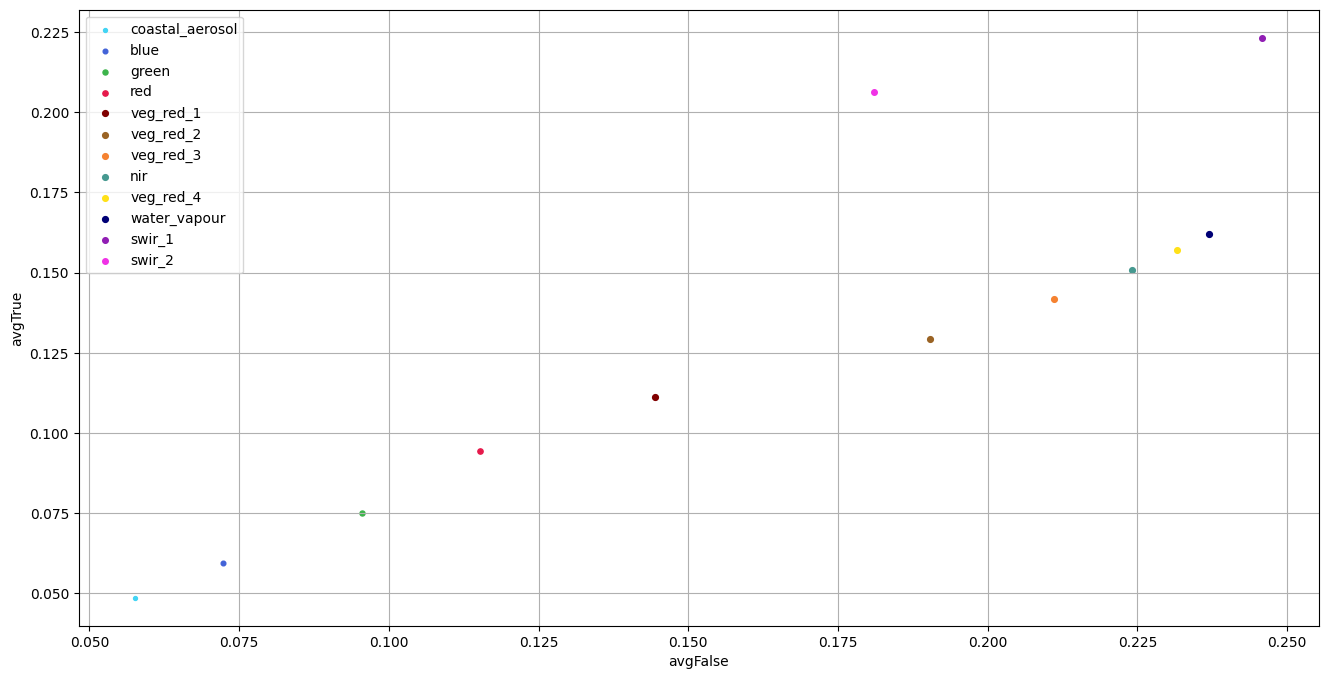

In [99]:
fig, ax = plt.subplots(figsize=(16, 8))

bands = globalAverage["postScores"]
for bandName in bands:

    band = bands[bandName]

    trueVariation = abs(band["maxTrue"] - band["minTrue"])
    

    
    ax.scatter(x = band["avgFalse"], 
            y = band["avgTrue"], 
            s = (1 + trueVariation) ** 3,
            c = BAND_COLORS[band["name"]],
            label=band["name"])

ax.set_xlabel("avgFalse")
ax.set_ylabel("avgTrue")
ax.grid(True)
plt.legend()
plt.show()